In [1]:
import numpy as np
import ipdb
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp 
from mpl_toolkits.mplot3d import Axes3D
import nbimporter
import dynamicalModels as dynamicalModels
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import norm

Importing Jupyter notebook from dynamicalModels.ipynb


# Simplex Projection

In [2]:
def make_manifold_point(X,E,tau,t):
    '''
    Creates point on a manifold embedded in R^E by time
    delaying the time series X by tau
    
    Args:
        X: Time series
        E: Dimension of embedding space
        tau: time delay
        t: a time point between (E-1)*tau < t < L
    Returns:
        X[range_revered_iterable]: a point in R^E.
    '''
    
    L = X.shape[0]
    range_iterable = range(t-(E-1)*tau,t+tau,tau)
    range_revered_iterable = list(reversed(range_iterable))
    return X[range_revered_iterable]

def make_manifold(X,E,tau):
    '''
    Creates a manifold embedded in R^E by time
    delaying the time series X by tau
    
    Args:
        X: Time series
        E: Dimension of embedding space
        tau: time delay
        
    Returns:
        embedding_x: a array of L - (E-1)*tau points
                    in R^E.
    '''
    
    # get length of time series
    L = X.shape[0]
    
    # initialize the embedding array matrix
    embedding_x =np.zeros((L - (E-1)*tau,E))
    
    i=0
    # create embedding matrix
    for t in range((E-1)*tau,L):
        # create a sequence of numbers between t-(E-1)*tau
        # and t+tau spaced by tau
    
        range_iterable = range(t-(E-1)*tau,t+tau,tau)
        
        #reverse the order of the sequence and coerce in a list
        range_revered_iterable = list(reversed(range_iterable))
        
        
        #put the entries of X at indices, range_revered_iterable,
        #in the ith row of embedding_x
        
        embedding_x[i,:] = X[range_revered_iterable]
        i+=1
    return embedding_x

def weight_function(distance):
    '''
    Exponentially weighted distance function
    
    Args:
        distance: a vector of distances
    Returns:
        u_i: normalized exponential weights
    '''
    
    non_indices=np.nonzero(distance)[0]
    if len(non_indices) == 0:
        norm_distance = 1
    else:
        norm_distance = distance[non_indices[0]]
    weighted_distance = np.exp(-distance/norm_distance)
    u_i = weighted_distance/np.sum(weighted_distance)
    return u_i

def simplex_projection(X,E,tau,p,library_fraction=0.5):
    '''
    Computes an estimate for the (1-library_fraction) fraction
    of X using the first library_fraction fraction of X. Given t=i
    in the second part of data, 1) compute the embedding manifold
    2) finding the nearest neighbours,S, of the time lagged point at t=i-p
    on the manifold 3) computing the time series at t=i by taking a 
    exponentially weighted average of entries of X assicated with S.
    
    Args: 
        X: time series to be approximated
        E: embedding dimension of manifold
        tau: time lag
        p: number of steps in future to guess
        library_fraction: fraction of data to be used
    
    Returns:
        X_estimate: X with first library_fraction fraction of  
                    X known and the next 1-library_fraction fraction
                    estimate using algorithm described above
    
    '''
    #length of X
    num_time_points = X.shape[0]
    
    #library size
    library_size = int(num_time_points*library_fraction)
    
    #initialize X_estimate
    X_estimate = np.zeros(num_time_points)*np.nan
    X_estimate[:library_size] = X[:library_size]
    
    #make manifolds
    entire_manifold = make_manifold(X,E,tau)
    xhat = make_manifold(X_estimate[:(library_size-p)],E,tau)
    starting_index =xhat.shape[0]
    ending_index = entire_manifold.shape[0]
    for i in range(starting_index,ending_index):
        #create time lagged manifold from X_estimate[:i-(p-1)]
        manifold_point = entire_manifold[i-p,:]
        
        #compute each points distance from the time lagged point
        # t = i-1 - (p-1)
        distance = norm(xhat-manifold_point,axis=1)
        #sorted indices of the smallest distance
        indices = np.argsort(distance)
        
         
        #Get E+1 the nearest distance and index of each point
        
        #Ignore the first since the time lagged point
        # t = i-1 - (p-1) itself
        nearest_inds = indices[0:E+1]
        nearest_dists = distance[nearest_inds]
        
        #compute exponential weights
        u_i = weight_function(nearest_dists)
        
        # estimate X at t = i by shifting the neighbours of the time lagged point
        # t = i-1 - (p-1) forward in time by p and taking a exponentially
        #weighted average of time points
        X_estimate[i + (E-1)*tau]= np.dot(X_estimate[nearest_inds + p + (E-1)*tau],u_i)
        
    return X_estimate 

def difference_vec(x):
    '''
    Compute the difference between consecutive points
    
    Args:
        x: data vector
    Returns:
        difference: difference vector
    '''
    difference = x[1:] - x[:-1]
    return difference

def correlation_plot(inital_data,E,tau,library_fraction=0.5,num_ps=10):
    '''
    Generate correlation plot between simplex_projection for p between 1
    and num_ps.
    
    Args: 
        inital_data: time series to be approximated
        E: embedding dimension of manifold
        tau: time lag
        library_fraction: fraction of data to be used
        num_ps: number of p's to use in simplex project
    
    Returns:
        correlation_vec: vector of correlations between the 
                         data and appromiated data for each p.
                         
    '''
    #difference data
    diff_data=difference_vec(inital_data)
    #length of data
    data_length = diff_data.shape[0]
    #length of the library
    library_length = int(library_fraction*data_length)
    #initialize correlation vector
    correlation_vec = np.zeros(num_ps)
    i=0
    for p in range(1,num_ps+1):
        #prediction for current p
        pred_vec = simplex_projection(diff_data,E,tau,p,library_fraction=frac)
        #compute correlation and store in correlation_vec
        corr =np.corrcoef(diff_data[library_length:],pred_vec[library_length:])
        correlation_vec[i] = corr[0,1]
        i=i+1
        
    #plot correlations
    index = [i for i in range(1,num_ps+1)]
    plt.plot(index,correlation_vec,'--s')
    plt.xlabel('Prediction Time ($T_p$)')
    plt.ylabel('Correlation Coefficient ($\\rho$)')
    return correlation_vec

## Detecting chaos in Tent Map 

In [3]:
def tent_map(r,N,x0):
    '''
    generates N length time series from tent map,
        x_n = r*x_{n-1} for x_{n-1}<0.5
              r*(1-x_{n-1}) for x_{n-1}>0.5
              
    Args:
        r:
            r parameter in tent map equation
        N:
            length of time series
        x0:
            initial value for the time series
    Returns:
        x:
            tent map time series of length N
    '''
    #initialize x
    x = np.zeros(N)
    x[0] = x0
    #generate time series for x
    for i in range(1,N):
        if (x[i-1] < 0.5):
            x[i] = r*x[i-1]
        if  (x[i-1] >= 0.5):
            x[i] = r*(1-x[i-1])
            
    return x

In [4]:
#plot of tent map and approximation withp =1
tent_x=tent_map(1.9999,1000,0.5)

In [5]:
diff_tent=difference_vec(tent_x)

# set parameters
E=3
tau=1
frac = 0.5
p=2

#compute length and predicted length
data_length = diff_tent.shape[0]
library_length = int(frac*data_length)

#compute prediction with simplex project
diff_tent_pred = simplex_projection(diff_tent,E,tau,p,library_fraction=frac)

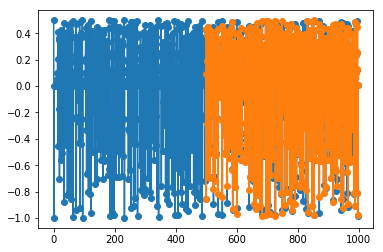

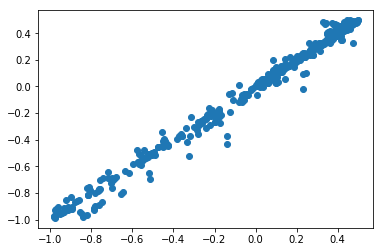

In [6]:
#plot data
pred_index = np.array([i for i in range(library_length,data_length)])
plt.plot(diff_tent,'-o')
plt.plot(pred_index,diff_tent_pred[library_length:],'-o')
plt.show()
plt.plot(diff_tent_pred[library_length:],diff_tent[library_length:],'o')
plt.show()

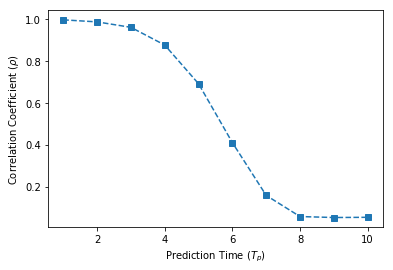

In [7]:
corr_data = correlation_plot(diff_tent,E,tau,library_fraction=frac)

## Detecting Chaos/Noise in Enzymatic Reaction modelled as a Markov Process with Gillespie Sampling

In [8]:
S = np.array([[-1, 1, 0, 0, 0, 0],
              [ 0, 0, 0, 0, 1, -1],
              [ 1,-1,-1, 1, 0, 0],
              [ 0, 0, 1,-1,-1, 1],
              [-1, 1, 0, 0, 1,-1]])
reaction_rates =np.array([1.0,1.0,2.0,1.0,1.0,1.0])
tinit = 0.0
tmax = 20.0

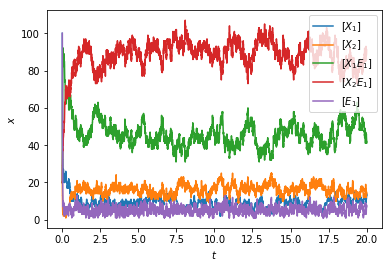

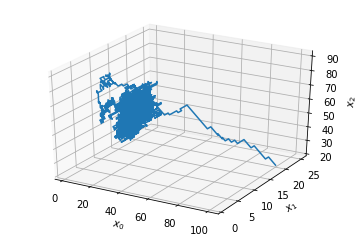

In [9]:
chemical_obj= dynamicalModels.enzymatic_reaction(S,reaction_rates)
sol = chemical_obj.solve_markov_process(tinit,tmax,np.array([100.0,20.0,20.0,20.0,100.0]))
chemical_obj.evolution_plot()
chemical_obj.trajectory_plot()

In [10]:
data = sol[1]
Y = data[:,1]
diff_Y=difference_vec(Y)

# set parameters
E=2*5+1
tau=1
frac = 0.5
p=2

#compute length and predicted length
data_length = diff_Y.shape[0]
library_length = int(frac*data_length)

#compute prediction with simplex project
diff_pred_Y = simplex_projection(diff_Y,E,tau,p,library_fraction=frac)

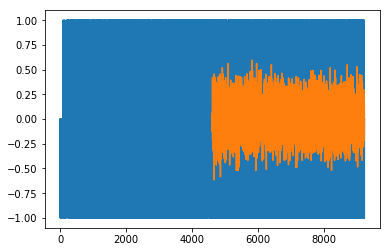

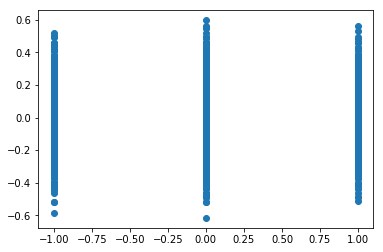

In [11]:
pred_index = np.array([i for i in range(library_length,data_length)])
plt.plot(diff_Y)
plt.plot(pred_index,diff_pred_Y[library_length:])
plt.show()
plt.plot(diff_Y[library_length:],diff_pred_Y[library_length:],'o')
plt.show()

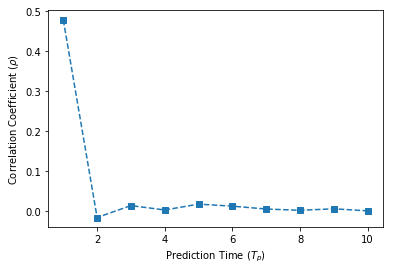

In [12]:
corr_data = correlation_plot(diff_Y,E,tau,library_fraction=frac)

## Detecting Chaos/Noise in Enzymatic Reaction modelled as a Markov Process with Gillespie Sampling

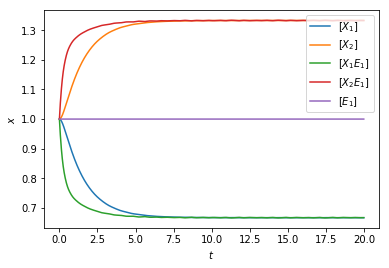

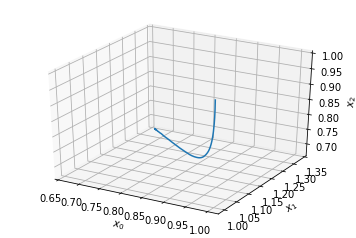

In [13]:
x0 = np.array([1.0,1.0,1.0,1.0,1.0])
dt = 0.01
sol = chemical_obj.integrate(tinit,tmax,dt,x0)
chemical_obj.evolution_plot()
chemical_obj.trajectory_plot()

In [14]:
data = sol.y
Y =data[1,:]
diff_Y=difference_vec(Y)

# set parameters
E=2*5+1
tau=1
frac = 0.5
p=2

#compute length and predicted length
data_length = diff_Y.shape[0]
library_length = int(frac*data_length)

#compute prediction with simplex project
diff_pred_Y = simplex_projection(diff_Y,E,tau,p,library_fraction=frac)

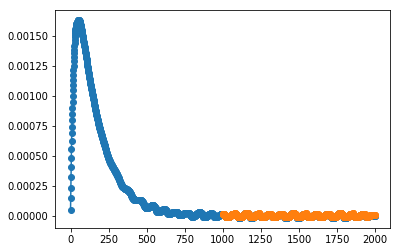

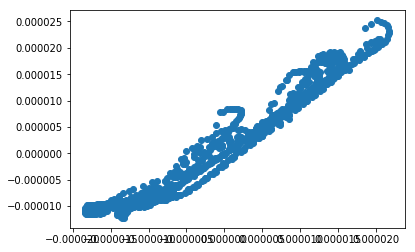

In [15]:
#plot data
pred_index = np.array([i for i in range(library_length,data_length)])
plt.plot(diff_Y,'-o')
plt.plot(pred_index,diff_pred_Y[library_length:],'-o')
plt.show()
plt.plot(diff_Y[library_length:],diff_pred_Y[library_length:],'o')
plt.show()

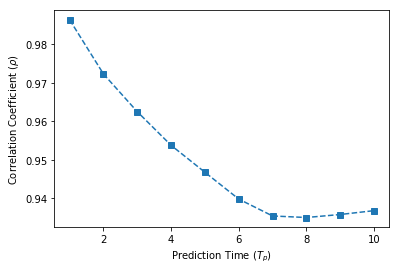

In [16]:
corr_data = correlation_plot(diff_Y,E,tau,library_fraction=frac)

## Detecting Chaos/Noise in Weiner Process

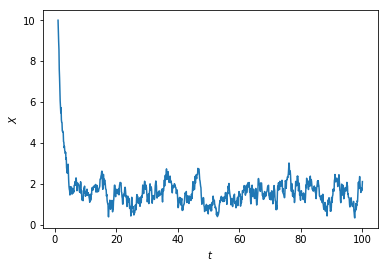

In [17]:
def a_fun(X):
    return 0.7*(1.5-X)
def b_fun(X):
    return 0.6

sodes= dynamicalModels.sdes(a_fun,b_fun)
sol = sodes.euler_maruyama(1.0,10.0,100.0,1000)
sodes.plot()

E=3
tau=1
frac = 0.5
p=2

In [18]:
data = sol[1]
Y = data
diff_Y=difference_vec(Y)

#compute length and predicted length
data_length = diff_Y.shape[0]
library_length = int(frac*data_length)

#compute prediction with simplex project
diff_pred_Y = simplex_projection(diff_Y,E,tau,p,library_fraction=frac)

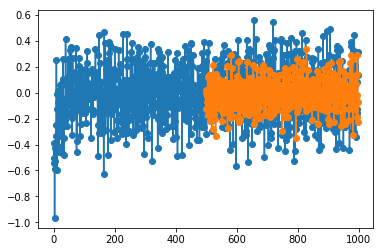

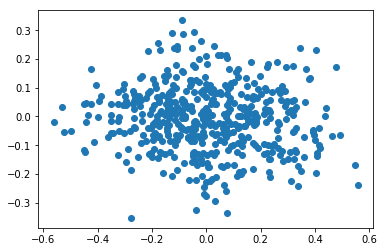

In [19]:
#plot data
pred_index = np.array([i for i in range(library_length,data_length)])
plt.plot(diff_Y,'-o')
plt.plot(pred_index,diff_pred_Y[library_length:],'-o')
plt.show()
plt.plot(diff_Y[library_length:],diff_pred_Y[library_length:],'o')
plt.show()

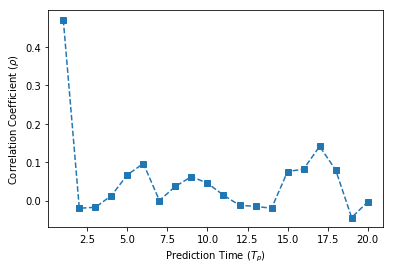

In [20]:
corr_data = correlation_plot(diff_Y,E,tau,library_fraction=frac,num_ps=20)